In [2]:
#!pip install stable-baselines3[extra]

# -- Prerequisites install 
!pip3 install stable_baselines3 --user
!pip3 install stable_baselines3 --user
!pip3 install ipykernel --user
!pip3 install tensorboard --user

^C


In [28]:

import stable_baselines3

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env


#from stable_baselines3 import DQN,PPO,A2C
from stable_baselines3 import PPO
import os


from hyperopt import hp,fmin,tpe
import torch as th
import math



def set_up_model(params, env):
    log_path = os.path.join('Training', 'Logs')
    hidden_layers_policy_network = params['hidden_layers_policy_network']
    size_hidden_layers_policy_network = params['size_hidden_layers_policy_network']
    hidden_layers_value_network = params['hidden_layers_value_network']
    size_hidden_layers_value_network = params['size_hidden_layers_value_network']

    net_arch = [dict(pi=([size_hidden_layers_policy_network] * hidden_layers_policy_network),vf=([size_hidden_layers_value_network] * hidden_layers_value_network))]

    activation_fn = {"tanh": th.nn.Tanh, "relu": th.nn.ReLU, "elu": th.nn.ELU, "leaky_relu": th.nn.LeakyReLU}[params['activation_fn']]

    policy_kwargs = dict(net_arch=net_arch,
                    ortho_init=params['ortho_init'],
                    activation_fn=activation_fn)

    batch_size = math.gcd(params['batch_size'],params['n_steps'])

    model = PPO("MlpPolicy",
                env, 
                learning_rate=params['learning_rate'], 
                n_steps=params['n_steps'], 
                batch_size=batch_size, 
                n_epochs=params['n_epochs'], 
                gamma=params['gamma'], 
                gae_lambda=params['gae_lambda'], 
                clip_range=params['clip_range'], 
                ent_coef=params['ent_coef'], 
                vf_coef=params['vf_coef'], 
                max_grad_norm=params['max_grad_norm'],
                policy_kwargs=policy_kwargs,
                verbose=0, 
                tensorboard_log=log_path,
                device='cuda')
    return model




space = {
        'learning_rate': 5e-6,
        'n_steps': 128,
        'batch_size': 128,
        'n_epochs': 10,
        'gamma': 0.99,
        'gae_lambda': 0.9,
        'clip_range': 0.2,
        'ent_coef': 0,
        'vf_coef': 0.5,
        'max_grad_norm': 0.5,
        'lr_schedule': 'linear',
        'hidden_layers_policy_network': 2,
        'size_hidden_layers_policy_network': 128,
        'hidden_layers_value_network': 2,
        'size_hidden_layers_value_network': 128,
        'ortho_init': False,
        'activation_fn': "relu"
    }


log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = BatteryEnv()
env = Monitor(env, log_dir)


check_env(env, warn=True)

print(hp.choice('hidden_layers_policy_network', [1,2,3,4]))

model = set_up_model(space,env)

model.learn(total_timesteps=1000)






0 switch
1   hyperopt_param
2     Literal{hidden_layers_policy_network}
3     randint
4       Literal{4}
5   Literal{1}
6   Literal{2}
7   Literal{3}
8   Literal{4}


C:\Users\A493191\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\policies.py:484: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


# STABLEBASELINES TESTBED

In [153]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union

#class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

class BatteryEnv(gym.Env):

   def __init__(self, nr_batteries, render_mode: Optional[str] = None):
      super().__init__()
      #self.zk = 9.8  # = SOC
      #self.hk = 1.0  # = hysteresis state
      #self.t = 1.0   # = temperature
      #self.vk = 1.0
      #self.rck = 1.0 # = Current through paralel resistor

      #     action_high = np.array(
      #       [
      #       #   10,         #min= 0, max= 10       Voltage (v) - vk
      #          80,        #min= 0, max= 100      SOC - zk
      #          80,        #min= 0, max= 100      SOC - zk
      #       #   150,        #min= -30, max= 150    Temperature  - t
      #       #   1,          #min= -1, max= 1       Hysteresis state - hk
      #       #   100,        #min= -100, max= 100   Current through paralel resistor - rck
      #       #   33459,      # time 
      #       #   np.finfo(np.float32).max,   #min= Inf, max= Inf
      #    ],
      #    dtype=np.float64,
      # )
      
      #...

      self.env_id = "Battery v0.3"
      self.num_envs = 1
      
      # SOHt​=f(SOCt​,CRt​) - soh as function of charge rate and soc
      # SOHt​=SOHt−1​−k×CRt​
      self.degradation_coeficient = 0.2

      self.soc_threshold_upper = 85
      self.soc_threshold_lower = 15

      self.episode_time = 0

      self.nr_batteries = nr_batteries



      high = np.array(
            [
               100,        #min= 0, max= 100      SOC - zk
               100,        #min= 0, max= 100      SOC - zk
         ],
         dtype=np.float32,
      )

      low = np.array(
            [
               0,
               0,
         ],
         dtype=np.float32,
      )


      self.action_space = gym.spaces.Box(-1, 1, (self.nr_batteries,), dtype=np.float32) # cell1,cell2,cell3... and voltage
      self.observation_space = gym.spaces.Box(0, 100, (self.nr_batteries,), dtype=np.float32)

      self.state = None
      self.steps_beyond_terminated = None
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."


      battery_current_values = get_converted_action(action)

      #vk, zk, t, hk, rck, time = self.state


      # discharge until 15, and 85 limilits
      #print(action)


      self.episode_time += 1
      passed_threshold = False
      exiting_observation_space = False

      self.state = np.subtract(self.state, battery_current_values)         

      for soc in self.state:

         if (soc < self.soc_threshold_lower or soc > self.soc_threshold_upper):
            passed_threshold = True
         if (soc < 0 or soc > 100):
            # EXITED OBSERVATION SPACE. Terminate immediatley.
            soc = 0.0
            exiting_observation_space = True
            print("//////// EXITED OBSERVATION SPACE BOUNDS ////////  "  + str(soc))
            #return np.array(self.state , dtype=np.float32), -10000000000000, True, False, {}




      # right now the reward in only based on if the variables fall out of bounds 
      # passed_thr = bool(
      #    soc0 < self.soc_threshold_lower
      #    or soc0 > self.soc_threshold_upper
      #    or soc1 < self.soc_threshold_lower
      #    or soc1 > self.soc_threshold_upper
      #    # time doesnt really make sense here for now
      #    #or time < 0
      #    #or time > 33458
      # )


      terminated = False

      reward = 0
      if not passed_threshold and self.episode_time == 128:
         # Timeout
         self.episode_time = 0
         # reward = 0
         reward = compute_ballancing_reward(self.state, False)
         terminated = True
      elif not passed_threshold:
         # Apply cost(reward)
         # if (math.isclose(soc0, soc1, abs_tol=1)):
         #    reward = 0
         # else:
         reward = compute_ballancing_reward(self.state, False)

      
      elif passed_threshold:
         # Batteries drained! Terminated.
         self.steps_beyond_terminated = 0
         
         #terminated = True
         #self.episode_time = 0
         reward = -1

         #if self.episode_time == 128:
         terminated = True

      # Sanity check. Do not continue steps after termination. Call reset first.
      # if self.steps_beyond_terminated > 0:
      #    print(
      #       "You are calling 'step()' even though this "
      #       "environment has already returned terminated = True. You "
      #       "should always call 'reset()' once you receive 'terminated = "
      #       "True' -- any further steps are undefined behavior."
      #    )
      #    self.steps_beyond_terminated += 1
      #    reward = 0.0


      if self.render_mode == "human":
         self.render()
      
      return np.array(self.state, dtype=np.float32), float(reward), terminated, False, {}
   

       


   def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,):
        

         super().reset(seed=seed)
         # Note that if you use custom reset bounds, it may lead to out-of-bound
         # state/observations.
         #high = utils.maybe_parse_reset_bounds(
         #    options, -0.05, 0.05  # default low
         #)  # default high


         self.episode_time = 0

         #definition of an episode: 1 whole run of the matlab script
         #                               OR
         #                          1 segment of it?

         self.state = self.np_random.uniform(low=15, high=85, size=(self.nr_batteries,))

         self.steps_beyond_terminated = None

         if self.render_mode == "human":
               self.render()
         return np.array(self.state, dtype=np.float32), {}



def compute_ballancing_reward(socs, should_print):

   
   #cost as distance between 2 numbers
   #reward = -pow(soc0 - soc1, 2)
   
   #cost as standard deviation

   value = np.std(socs, dtype=np.float32)
   value = (value - 0) / (35.36 - 0)
   reward = 1-value

   # if(should_print):
   #    print( "SOC Mean: " + str(mean) +  "    ---- SOC1 Difference    "  + str(difference1)  +  "    ----   SOC2 Difference    "  + str(difference2))

   return reward


def get_converted_action(action):
   current_values = []
   for current in action:
      shifted_value = (current + 1.0) * 5.0  #from [-1, 1] to [0, 10]
      current_values.append(shifted_value)

   return current_values




In [44]:
import torch

def plot_step(episode_number, state, action, reward, show_result=False):
    
    fig = plt.figure(1)

    actions_t = torch.tensor(action, dtype=torch.float)
    rewards_t = torch.tensor(reward, dtype=torch.float)

    plt.title('Episode ' + str(episode_number))
    plt.xlabel('Step')
    plt.ylabel('SOC & Actions')



    # Plot SOCs
    soc0 = []
    soc1 = []
    for st in state:
        # states_t = torch.tensor(st, dtype=torch.float)
        # plt.plot(states_t.cpu().squeeze().numpy(), label='State ' + str(st))

        soc0.append(st[0][0].item())
        soc1.append(st[0][1].item())
    
    plt.plot(soc0, label='soc0')
    plt.plot(soc1, label='soc1')



    # Plot actions as indvidual points
    action_array = np.multiply(actions_t.numpy(), 10)   # multiply action values by 10 for better display on graph
    plt.plot(action_array, 'bo', markersize=0.4, label='Action')
    line_nr = 0

    # Plot action value as text above point
    # for line in action_array:
    #     plt.text(line_nr, line+1.8, str(int(line)), horizontalalignment='center', size='small', color='black')
    #     line_nr = line_nr + 1 


    # Plot actions as single point average
    # Take 100 steps average and plot the average action for that period
    # if len(actions_t) >= 10:
    #     means = actions_t.unfold(0, 10, 1).mean(1).view(-1)
    #     means = torch.cat((torch.zeros(9), means))
    #     plt.plot(means.numpy(), 'go', markersize=1, label='Action')

    plt.legend()



    # Plot rewards
    # Reduces displayed rewards by an order of 10 to fit within the graph
    fig2 = plt.figure(2)
    plt.title('Episode ' + str(episode_number))
    plt.xlabel('Step')
    plt.ylabel('Reward')
    #plt.plot(np.divide(rewards_t.numpy(), 10), label='Reward')
    plt.plot(rewards_t.numpy(), label='Reward')

    # add legend with labels
    plt.legend()




    plt.pause(0.0001)  # pause a bit so that plots are updated
    #if is_ipython:
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())


In [13]:
# NOT FUNCTIONAL

class TimeLimitWrapper(gym.Wrapper):
    """
    :param env: (gym.Env) Gym environment that will be wrapped
    :param max_steps: (int) Max number of steps per episode
    """

    def __init__(self, env, max_steps=100):
        # Call the parent constructor, so we can access self.env later
        super(TimeLimitWrapper, self).__init__(env)
        self.max_steps = max_steps
        # Counter of steps per episode
        self.current_step = 0

        # PLOT CODE
        # self.episode_durations = []
        self.current_episode_states = []
        self.current_episode_actions = []
        self.current_episode_rewards = []


    def reset(self, **kwargs):
        """
        Reset the environment
        """
        # Reset the counter
        self.current_step = 0
        print("dsdsdsdsds")
        return self.env.reset(**kwargs)

    def step(self, action):
        """
        :param action: ([float] or int) Action taken by the agent
        :return: (np.ndarray, float, bool, bool, dict) observation, reward, is the episode over?, additional informations
        """
        self.current_step += 1
        obs, reward, terminated, truncated, info = self.env.step(action)

        print("dsdsdsdsds")

        # PLOT CODE
        self.current_episode_states.append(self.env.state)
        self.current_episode_actions.append(action[0].item())
        self.current_episode_rewards.append(reward)

        plot_step(1, self.current_episode_states,  self.current_episode_actions,  self.current_episode_rewards)

        # Overwrite the truncation signal when when the number of steps reaches the maximum
        if self.current_step >= self.max_steps:
            truncated = True
        return obs, reward, terminated, truncated, info

In [184]:
import stable_baselines3

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.env_checker import check_env


#from stable_baselines3 import DQN,PPO,A2C
from stable_baselines3 import PPO
import os


from hyperopt import hp,fmin,tpe
import torch
import math


import numpy as np
from typing import Optional, Union



class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            # print(x[-100:])
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"SAVE CALLBACK: Num timesteps: {self.num_timesteps}")
                    print(
                        f"SAVE CALLBACK Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )
                    #print (self.training_env.state)

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"SAVE CALLBACK: Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True
    




In [209]:
# !pip install gymnasium[box2d]
import gymnasium as gym
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv

from stable_baselines3.common.env_checker import check_env

from stable_baselines3.common.vec_env.vec_monitor import VecMonitor



# Create log dir
log_dir = "./tmp/gym/ppotest/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
#env = gym.make("LunarLanderContinuous-v2")
env = BatteryEnv(5, False)
# env = gym.wrappers.TimeLimit(env, max_episode_steps = 500)
# env = gym.wrappers.AutoResetWrapper(env)

for i in range(0, 100):
    check_env(env)

# OrderEnforcing -- throw error if step is caled before reset

#end = TimeLimitWrapper(env, max_steps=50)   -- NOT FUNCTUONAL ON THIS IMPL
# Logs will be saved in log_dir/monitor.csv 


env = DummyVecEnv([lambda: env])
# env = VecNormalize(env, norm_reward=False, norm_obs=False)
env = VecMonitor(env, log_dir) #monitor for vec environments

#env = Monitor(env, log_dir) #monitor for raw environments



# run random env tests tomake sure everything is in order
# for i in range(0, 100):
#     check_env(env)


#env = gym.wrappers.RecordEpisodeStatistics(env, 500)



In [210]:
from stable_baselines3 import A2C, SAC, PPO, TD3

from stable_baselines3.common.policies import ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy


print("Is CUDA enabled?", torch.cuda.is_available())


# Create action noise because TD3 and DDPG use a deterministic policy
#n_actions = env.action_space.shape[-1]
#action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Create the callback: check every 1000 steps
#callback = SaveOnBestTrainingRewardCallback(check_freq=512, log_dir=log_dir)

# Create RL model
#model = PPO('MlpPolicy', env, verbose=0, device="cuda", tensorboard_log="./ppo_tensorboard_log/", learning_rate=1e-4, gamma=0.20)


hyperparameters = {
    'learning_rate': 0.0003,  # Learning rate
    'n_steps': 2048,  # Number of steps per epoch
    'batch_size': 256,  # Minibatch size for SGD
    'ent_coef': 0.01,  # Entropy coefficient for exploration
    # 'gamma': 0.99,  # Discount factor
    'gae_lambda': 0.95,  # Lambda coefficient (controls bias-variance trade-off in advantage estimation)
    'clip_range': 0.2,  # Clip range for PPO clip loss
    'n_epochs': 4,  # Number of epochs per update
    'max_grad_norm': 0.5,  # Max norm of gradients
    'vf_coef': 0.5,  # Value function coefficient in the total loss
    # 'use_sde': False,  # Whether to use Squashed Diagonal Gaussian policy
    # 'sde_sample_freq': -1,  # Sample frequency for SDE when `use_sde=True`
}

model = PPO('MlpPolicy', env, verbose=0, device="cuda", tensorboard_log="./ppo_tensorboard_log/", policy_kwargs={'net_arch':dict(pi=[256, 256, 256],
                                                                                                                                 vf=[256, 256, 256])}, **hyperparameters)

# model = A2C('MlpPolicy', env, verbose=0, device="cuda", tensorboard_log="./ppo_tensorboard_log/", policy_kwargs={'net_arch':dict(pi=[256, 256, 256],
#                                                                                                                                  vf=[256, 256, 256])}, **hyperparameters)



callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 20, eval_freq= 20*128)


Is CUDA enabled? True


Eval num_timesteps=1280, episode_reward=68.04 +/- 16.74
Episode length: 128.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2560, episode_reward=69.92 +/- 20.00
Episode length: 128.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3840, episode_reward=68.68 +/- 16.60
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=68.87 +/- 20.60
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=66.68 +/- 18.01
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=68.60 +/- 22.57
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=60.15 +/- 16.60
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=57.73 +/- 15.66
Episode length: 128.00 +/- 0.00


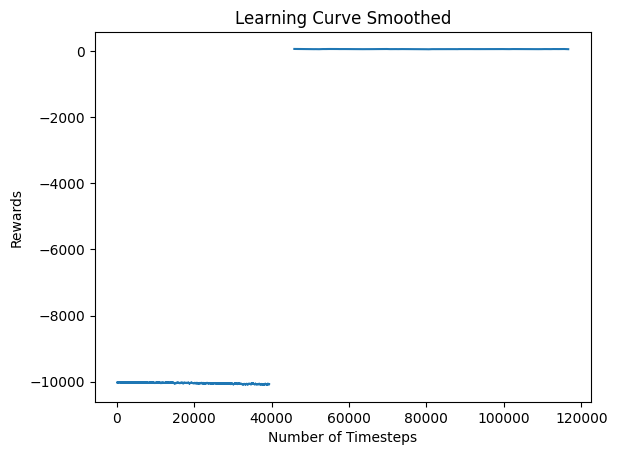

Eval num_timesteps=1280, episode_reward=67.90 +/- 15.25
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=61.89 +/- 15.53
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=75.44 +/- 20.33
Episode length: 128.00 +/- 0.00
New best mean reward!
Eval num_timesteps=5120, episode_reward=65.65 +/- 8.53
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=65.09 +/- 13.07
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=60.00 +/- 10.36
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=71.32 +/- 20.51
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=70.44 +/- 15.64
Episode length: 128.00 +/- 0.00


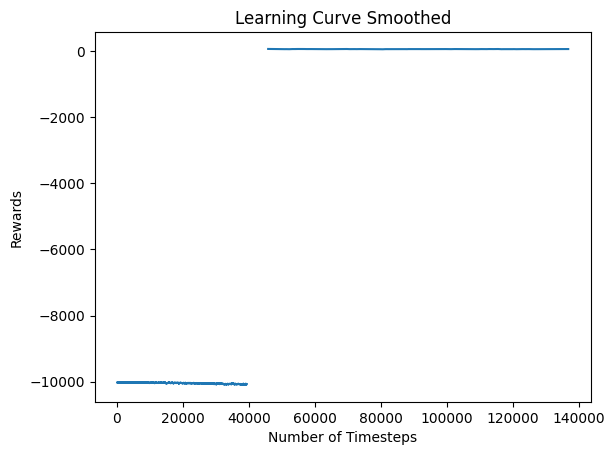

Eval num_timesteps=1280, episode_reward=58.85 +/- 17.95
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=64.47 +/- 16.52
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=63.45 +/- 25.52
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=59.17 +/- 19.39
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=59.78 +/- 17.34
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=58.97 +/- 19.10
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=64.87 +/- 13.84
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=66.40 +/- 20.23
Episode length: 128.00 +/- 0.00


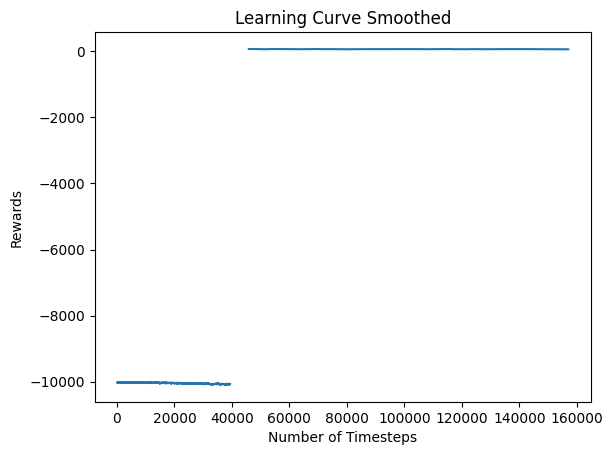

Eval num_timesteps=1280, episode_reward=58.39 +/- 9.81
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=66.73 +/- 15.54
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=70.40 +/- 13.18
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=58.76 +/- 20.01
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=64.66 +/- 9.36
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=69.99 +/- 15.89
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=66.92 +/- 17.96
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=69.58 +/- 18.02
Episode length: 128.00 +/- 0.00


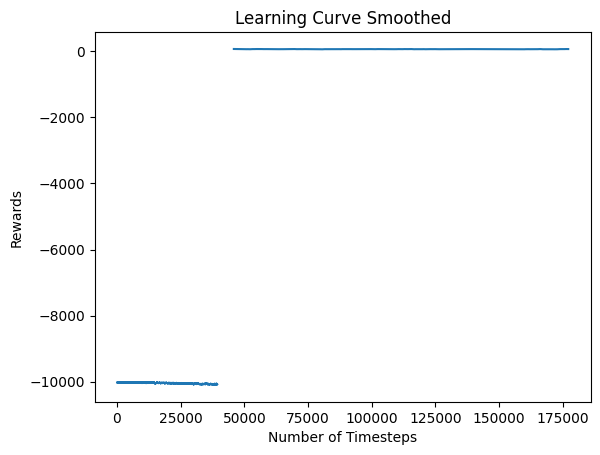

Eval num_timesteps=1280, episode_reward=58.39 +/- 15.54
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=78.27 +/- 20.67
Episode length: 128.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3840, episode_reward=61.15 +/- 19.16
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=65.66 +/- 14.76
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=75.09 +/- 21.72
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=64.38 +/- 14.76
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=66.02 +/- 11.27
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=64.66 +/- 13.08
Episode length: 128.00 +/- 0.00


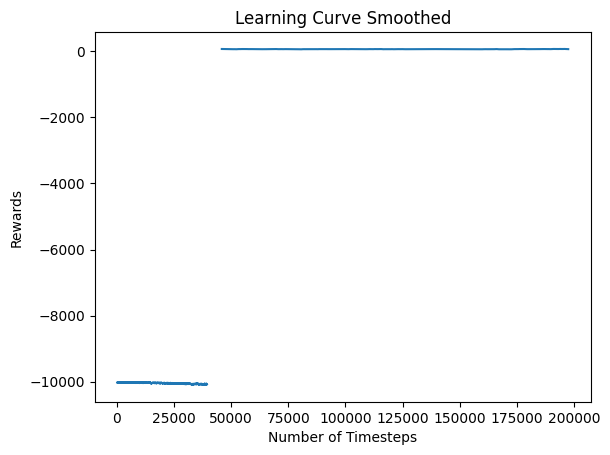

Eval num_timesteps=1280, episode_reward=64.60 +/- 16.38
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=73.02 +/- 16.88
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=62.96 +/- 18.82
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=67.79 +/- 14.69
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=70.59 +/- 14.60
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=70.02 +/- 18.80
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=67.91 +/- 18.46
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=49.55 +/- 12.98
Episode length: 128.00 +/- 0.00


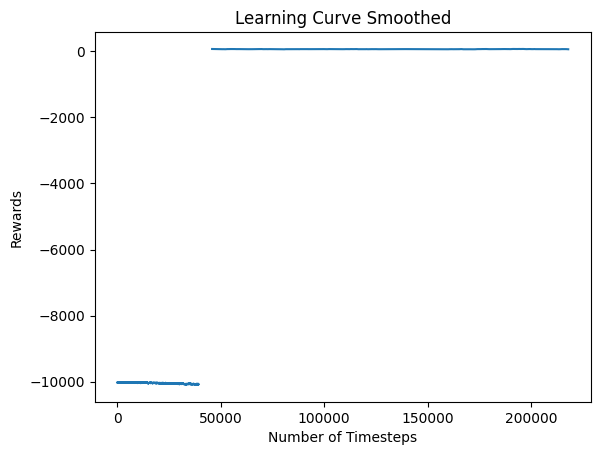

Eval num_timesteps=1280, episode_reward=59.70 +/- 13.95
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=67.12 +/- 13.72
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=62.57 +/- 13.35
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=60.22 +/- 19.12
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=60.97 +/- 15.51
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=60.54 +/- 17.97
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=58.15 +/- 10.37
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=69.78 +/- 23.05
Episode length: 128.00 +/- 0.00


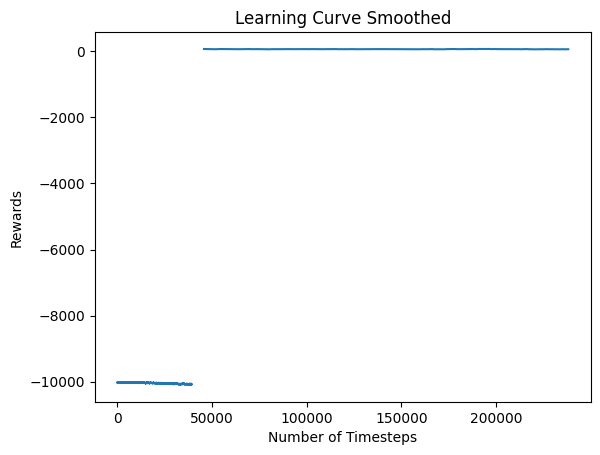

Eval num_timesteps=1280, episode_reward=55.67 +/- 24.57
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=61.75 +/- 12.02
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=64.59 +/- 17.24
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=73.61 +/- 17.25
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=59.91 +/- 10.41
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=78.61 +/- 19.76
Episode length: 128.00 +/- 0.00
New best mean reward!
Eval num_timesteps=8960, episode_reward=66.09 +/- 14.55
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=62.43 +/- 12.56
Episode length: 128.00 +/- 0.00


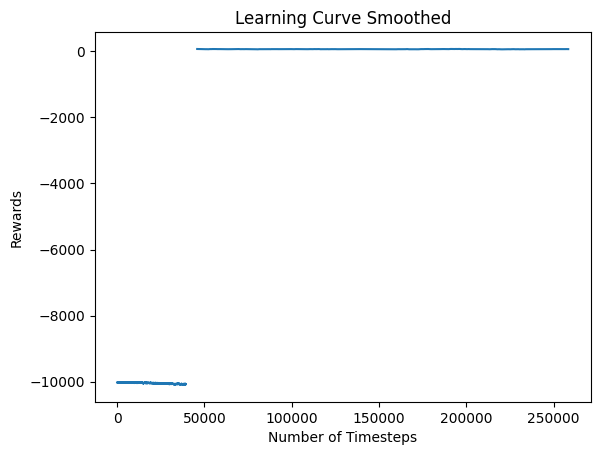

Eval num_timesteps=1280, episode_reward=65.12 +/- 14.12
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=53.47 +/- 14.14
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=56.01 +/- 14.66
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=61.29 +/- 21.18
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=72.27 +/- 23.80
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=67.12 +/- 10.72
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=73.55 +/- 12.40
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=69.36 +/- 19.71
Episode length: 128.00 +/- 0.00


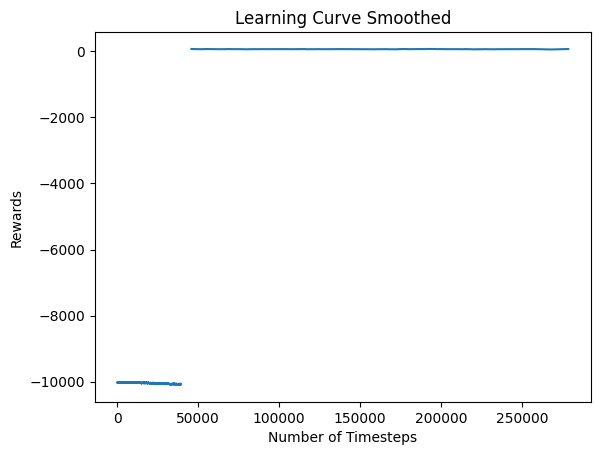

Eval num_timesteps=1280, episode_reward=59.69 +/- 8.98
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=56.50 +/- 15.18
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=56.49 +/- 16.29
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=71.20 +/- 12.46
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=68.97 +/- 22.06
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=57.95 +/- 17.14
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=65.75 +/- 12.59
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=67.12 +/- 19.47
Episode length: 128.00 +/- 0.00


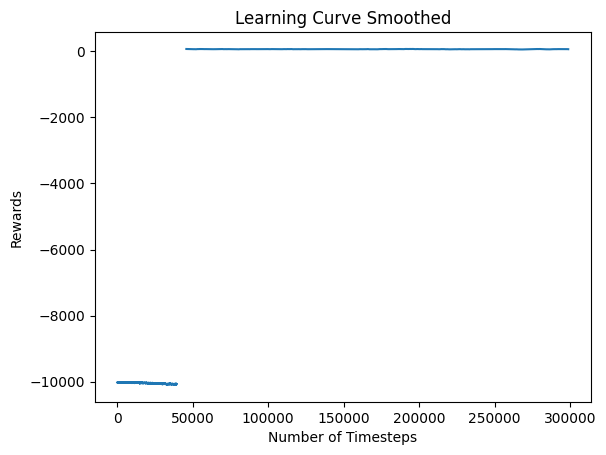

Eval num_timesteps=1280, episode_reward=76.15 +/- 21.65
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=68.20 +/- 12.33
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=70.44 +/- 17.35
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=65.78 +/- 16.19
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=69.09 +/- 13.98
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=55.60 +/- 11.74
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=81.66 +/- 18.04
Episode length: 128.00 +/- 0.00
New best mean reward!
Eval num_timesteps=10240, episode_reward=72.23 +/- 19.50
Episode length: 128.00 +/- 0.00


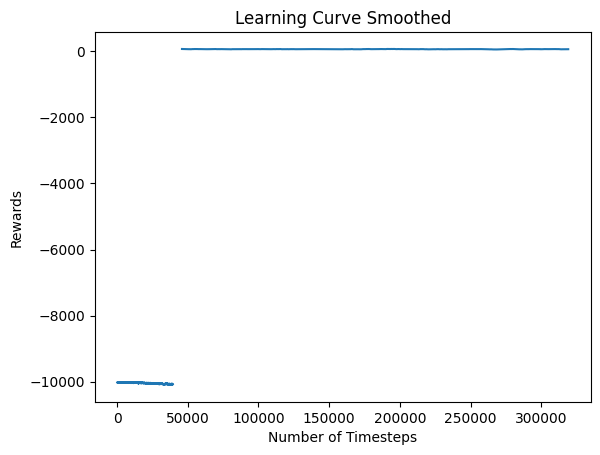

Eval num_timesteps=1280, episode_reward=55.74 +/- 11.56
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=73.90 +/- 21.17
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=67.68 +/- 9.92
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=66.46 +/- 20.40
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=65.12 +/- 17.64
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=62.69 +/- 15.13
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=69.54 +/- 17.95
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=71.18 +/- 18.57
Episode length: 128.00 +/- 0.00


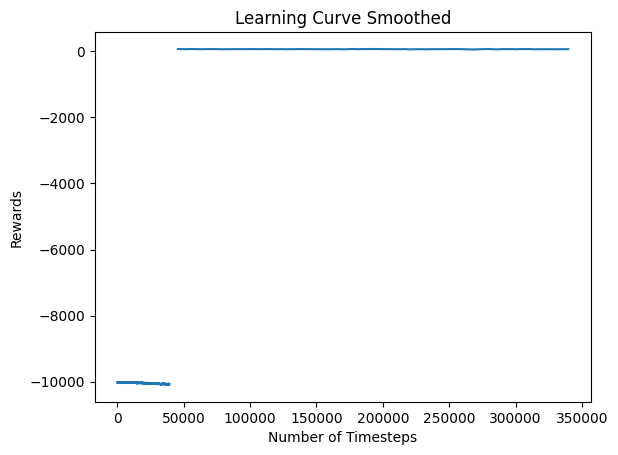

Eval num_timesteps=1280, episode_reward=72.55 +/- 13.99
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=65.26 +/- 14.06
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=64.93 +/- 13.22
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=61.40 +/- 19.75
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=73.51 +/- 21.24
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=54.45 +/- 15.81
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=71.36 +/- 19.78
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=58.01 +/- 19.92
Episode length: 128.00 +/- 0.00


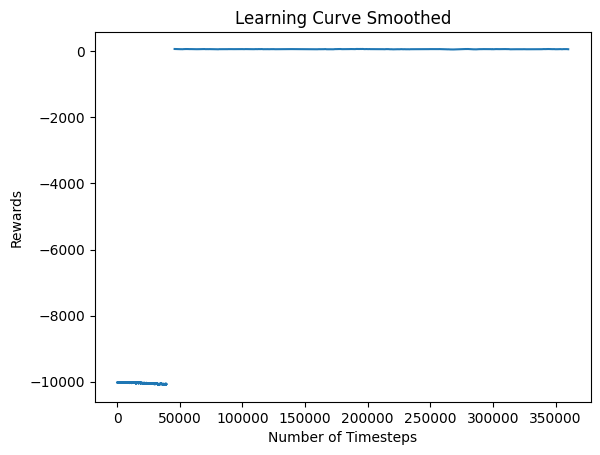

Eval num_timesteps=1280, episode_reward=62.90 +/- 20.37
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=70.40 +/- 16.42
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=62.61 +/- 12.20
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=65.36 +/- 19.45
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=64.15 +/- 19.19
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=58.90 +/- 16.56
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=62.28 +/- 12.78
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=64.48 +/- 11.77
Episode length: 128.00 +/- 0.00


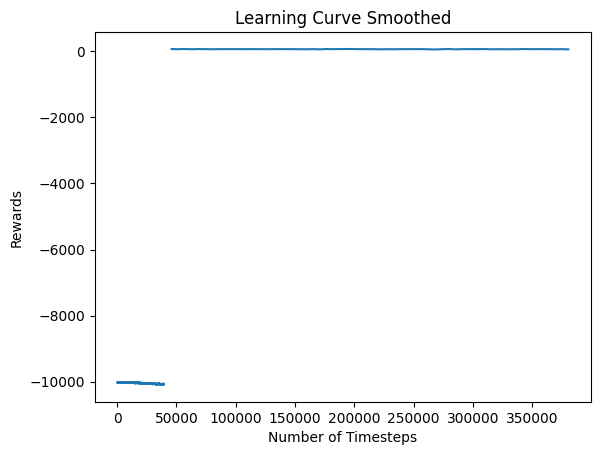

Eval num_timesteps=1280, episode_reward=69.33 +/- 14.10
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=57.86 +/- 12.46
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=64.13 +/- 13.58
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=63.55 +/- 19.49
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=55.33 +/- 8.98
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=61.40 +/- 16.15
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=73.76 +/- 19.48
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=66.49 +/- 16.51
Episode length: 128.00 +/- 0.00


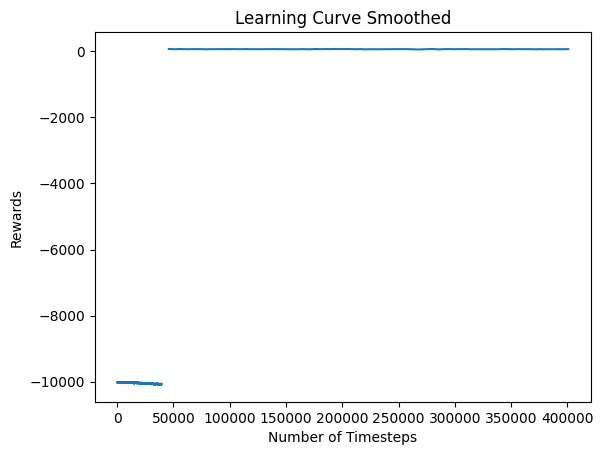

Eval num_timesteps=1280, episode_reward=64.89 +/- 19.89
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=60.75 +/- 19.38
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=60.28 +/- 19.01
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=73.54 +/- 15.75
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=60.64 +/- 5.13
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=71.17 +/- 16.50
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=62.02 +/- 22.65
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=71.04 +/- 16.13
Episode length: 128.00 +/- 0.00


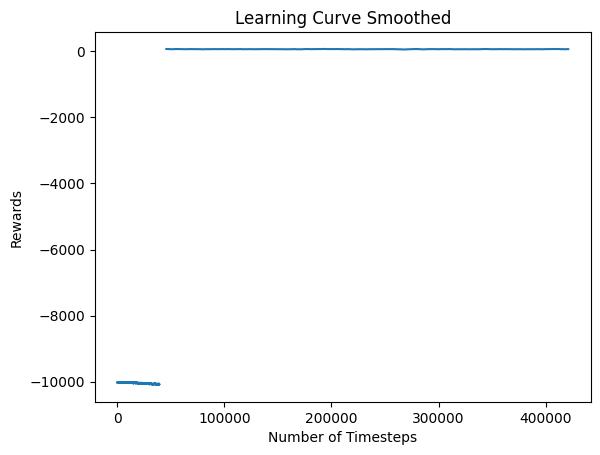

Eval num_timesteps=1280, episode_reward=60.52 +/- 17.05
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=59.66 +/- 19.39
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=67.57 +/- 18.20
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=58.69 +/- 17.65
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=67.94 +/- 16.04
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=63.58 +/- 13.32
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=63.66 +/- 13.49
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=64.46 +/- 20.55
Episode length: 128.00 +/- 0.00


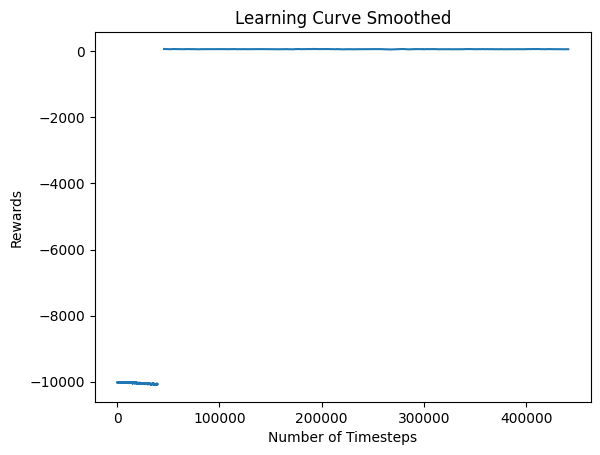

Eval num_timesteps=1280, episode_reward=70.83 +/- 19.07
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=57.84 +/- 14.45
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=69.17 +/- 21.33
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=63.51 +/- 12.20
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=64.87 +/- 17.85
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=59.69 +/- 23.64
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=57.76 +/- 15.93
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=71.35 +/- 13.63
Episode length: 128.00 +/- 0.00


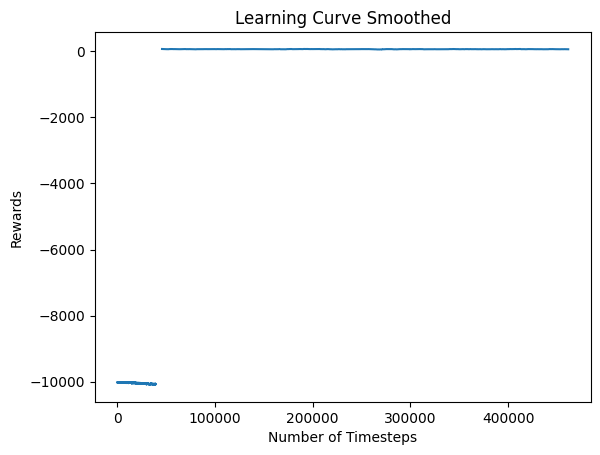

Eval num_timesteps=1280, episode_reward=64.09 +/- 14.46
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=64.72 +/- 18.16
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=66.17 +/- 11.27
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=61.17 +/- 12.39
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=70.51 +/- 20.95
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=62.50 +/- 19.97
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=69.58 +/- 18.48
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=65.19 +/- 13.16
Episode length: 128.00 +/- 0.00


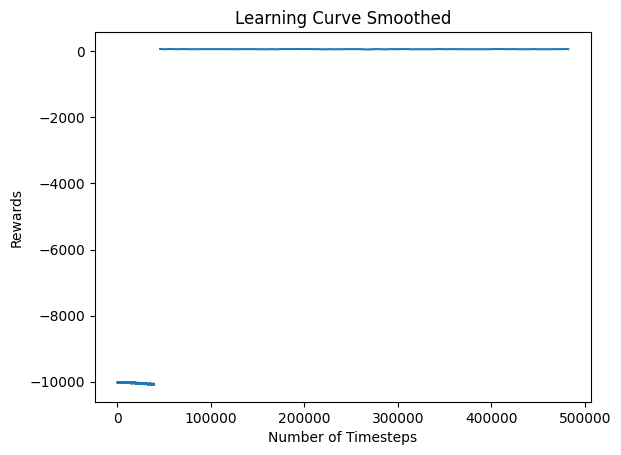

Eval num_timesteps=1280, episode_reward=73.05 +/- 18.26
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=64.64 +/- 13.73
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=63.29 +/- 15.75
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=61.44 +/- 15.77
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=62.07 +/- 15.85
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=62.66 +/- 11.69
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=66.95 +/- 17.40
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=75.47 +/- 20.33
Episode length: 128.00 +/- 0.00


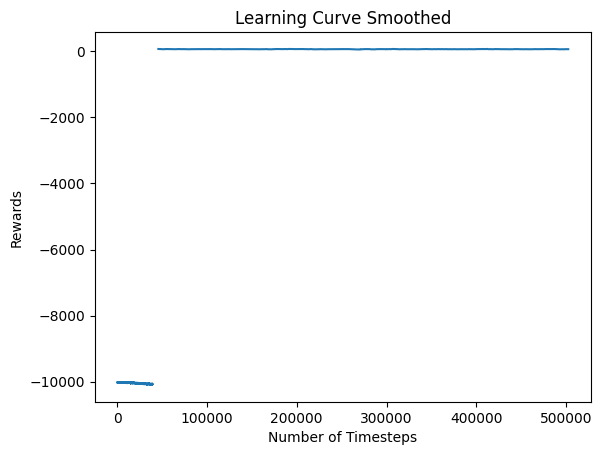

Eval num_timesteps=1280, episode_reward=61.80 +/- 14.22
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=62.50 +/- 15.71
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=60.34 +/- 13.13
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=70.19 +/- 17.73
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=61.29 +/- 13.39
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=60.90 +/- 13.08
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=56.76 +/- 12.82
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=60.20 +/- 18.36
Episode length: 128.00 +/- 0.00


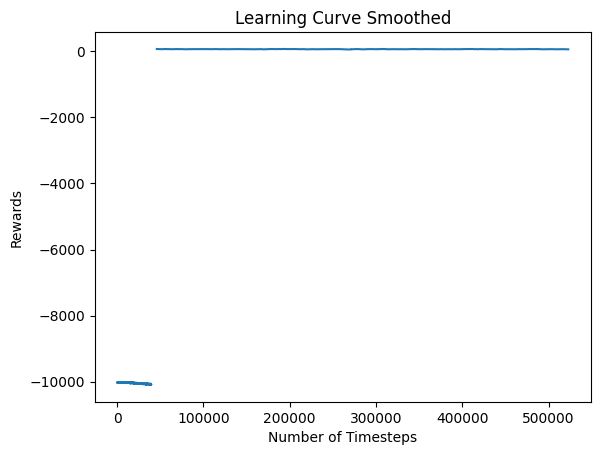

Eval num_timesteps=1280, episode_reward=61.60 +/- 15.57
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=62.08 +/- 13.63
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=71.29 +/- 24.49
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=67.01 +/- 18.60
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=67.57 +/- 15.07
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=69.73 +/- 21.88
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=59.11 +/- 12.11
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=71.66 +/- 12.82
Episode length: 128.00 +/- 0.00


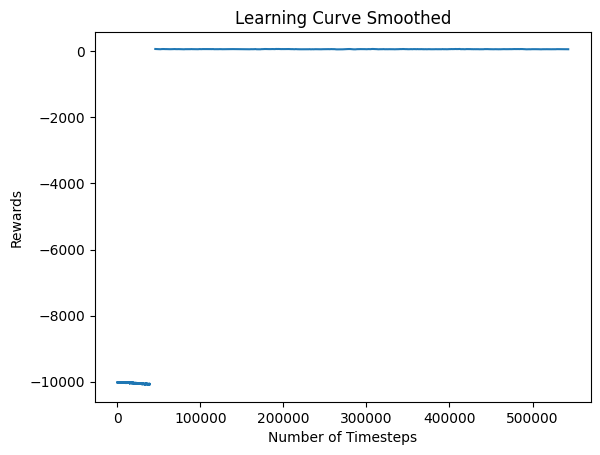

Eval num_timesteps=1280, episode_reward=65.74 +/- 9.67
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=56.79 +/- 8.95
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=80.87 +/- 16.46
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=61.57 +/- 21.47
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=71.81 +/- 21.34
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=69.81 +/- 15.42
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=66.99 +/- 13.12
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=62.43 +/- 15.33
Episode length: 128.00 +/- 0.00


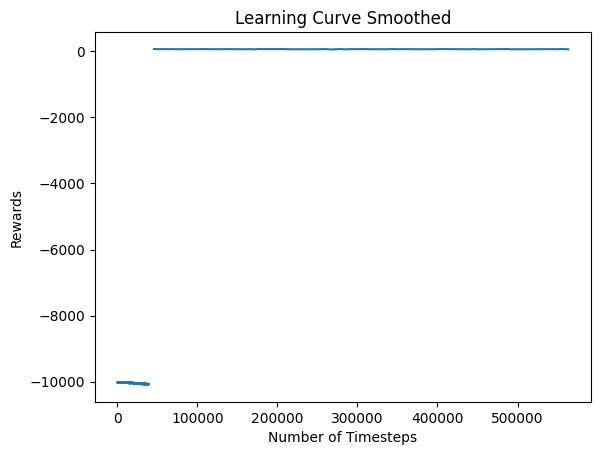

Eval num_timesteps=1280, episode_reward=65.55 +/- 18.02
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=67.80 +/- 13.90
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=64.51 +/- 19.45
Episode length: 128.00 +/- 0.00
Eval num_timesteps=5120, episode_reward=66.53 +/- 19.39
Episode length: 128.00 +/- 0.00
Eval num_timesteps=6400, episode_reward=60.47 +/- 11.45
Episode length: 128.00 +/- 0.00
Eval num_timesteps=7680, episode_reward=66.68 +/- 19.12
Episode length: 128.00 +/- 0.00
Eval num_timesteps=8960, episode_reward=70.21 +/- 9.02
Episode length: 128.00 +/- 0.00
Eval num_timesteps=10240, episode_reward=70.96 +/- 17.46
Episode length: 128.00 +/- 0.00


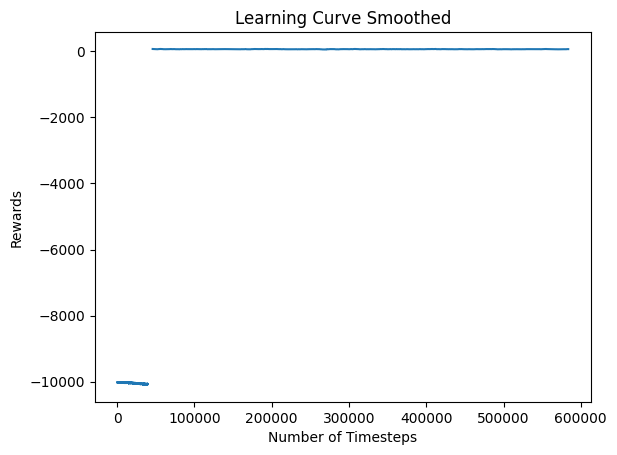

Eval num_timesteps=1280, episode_reward=57.92 +/- 11.33
Episode length: 128.00 +/- 0.00
Eval num_timesteps=2560, episode_reward=56.52 +/- 9.43
Episode length: 128.00 +/- 0.00
Eval num_timesteps=3840, episode_reward=60.05 +/- 13.57
Episode length: 128.00 +/- 0.00


KeyboardInterrupt: 

In [264]:
from stable_baselines3.common import results_plotter

#print(model.policy)
normal_eval_callback=EvalCallback(env, log_path=log_dir, n_eval_episodes= 10, eval_freq= 10*128)

# Train the agent
for i in range(0, 30):
    model.learn(total_timesteps=int(10000), callback=normal_eval_callback)
    plot_results(log_dir)





# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e6, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)


# reduce samples: callback: eval callback episodes and eval_freq
#                 env: n_steps, n_epochs, batch_size


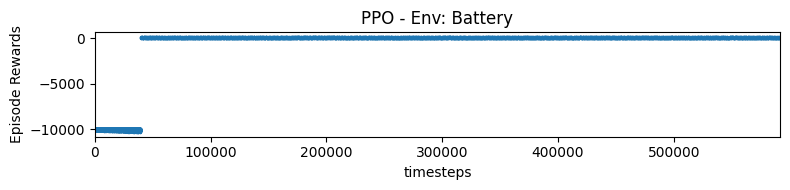

In [265]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)


In [266]:
import matplotlib.pyplot as plt


def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

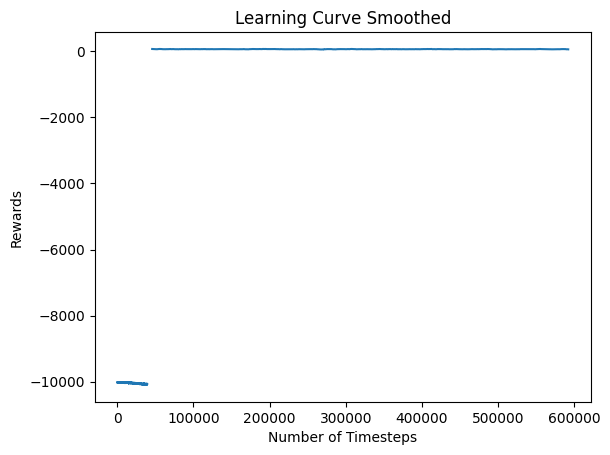

In [267]:

plot_results(log_dir)


# study value and policy more
# view episides during training

[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  ACTION:[0. 0. 0. 0. 0.]  >>>> 
[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  REWARD:  [0.6472445]   
[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  ACTION:[0. 0. 0. 0. 0.]  >>>> 
[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  REWARD:  [0.6472445]   
[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  ACTION:[0. 0. 0. 0. 0.]  >>>> 
[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  REWARD:  [0.6472445]   
[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  ACTION:[0. 0. 0. 0. 0.]  >>>> 
[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  REWARD:  [0.6472445]   
[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  ACTION:[0. 0. 0. 0. 0.]  >>>> 
[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  REWARD:  [0.6472445]   
[[28.24254   21.750193  34.393948  15.4804325 51.845985 ]]  ACTION:[0.      0.      0.      0.      2.44659]  >>>> 
[[28.2425

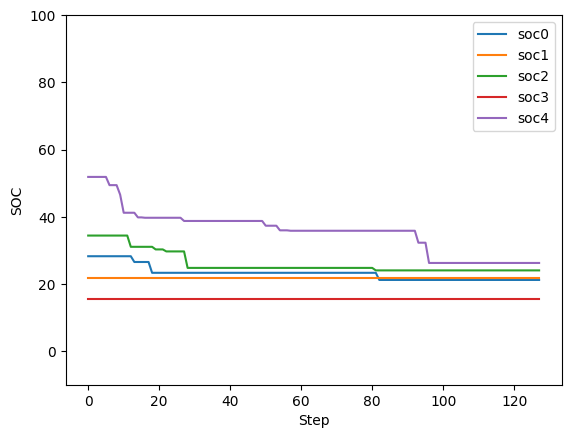

In [273]:
import time



def test_trained_model():
    obs = model.get_env().reset()
    episode_reward = 0

    obsArray = []

    while True:
        obsArray.append(obs)
        action, _states = model.predict(obs)
        oldObs = obs
        obs, rewards, done, info = model.get_env().step(action)
        episode_reward += rewards.squeeze()

        if not done:
            print(str(oldObs) + "  ACTION:" + str(get_converted_action(action)[0]) + "  >>>> ")
            print(str(obs) + "  REWARD:  "  + str(rewards) + "   ")
        else:
            info_item = info.pop()
            print("FINAL: ")
            print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
            print(str(str(get_converted_action(action.flatten()))))
            print("REWARD:  " + str(rewards[0]))
            print("EPISODE TOTAL REWARD: " + str(episode_reward))

            # plot final model
            fig = plt.figure(1)

            data_np = np.array(obsArray)

            plt.xlabel('Step')
            plt.ylabel('SOC')
            print("------------------------------------------------------")
            plt.ylim([-10, 100])


            i = 0
            for soc in data_np.T:
                plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
                i += 1

            plt.legend()
            #plt.pause(3)

            obsArray = []
            episode_reward = 0
            obs = model.get_env().reset()

            #time.sleep(0.5)
            break


# def test_paralel_model():

#     env = BatteryEnv(5, False)
#     env = DummyVecEnv([lambda: env])

#     # intialized here
#     obs = env.reset()
    
#     episode_reward = 0
#     obsArray = []

#     while True:
#         action, _states = model.predict(obs)
#         oldObs = obs
#         obs, rewards, done, info = model.get_env().step(action)
#         episode_reward += rewards.squeeze()

#         print(str(oldObs) + "  ACTION:" + str(action) + "  >>>> ")


#         if not done:
#             print(str(oldObs) + "  ACTION:" + str(action) + "  >>>> ")
#             print(str(obs) + "  REWARD:  "  + str(rewards) + "   ")
#         else:
#             info_item = info.pop()
#             print("FINAL: ")
#             print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
#             print(str(str(action.flatten())))
#             print("REWARD:  " + str(rewards[0]))
#             print("EPISODE TOTAL REWARD: " + str(episode_reward))

#             # plot final model
#             fig = plt.figure(1)

#             data_np = np.array(obsArray)

#             plt.xlabel('Step')
#             plt.ylabel('SOC')
#             print("------------------------------------------------------")
#             plt.ylim([-10, 100])


#             i = 0
#             for soc in data_np.T:
#                 plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
#                 i += 1

#             plt.legend()
#             #plt.pause(3)

#             obsArray = []
#             episode_reward = 0
#             obs = model.get_env().reset()

#             break




test_trained_model()


In [22]:
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.vec_env import DummyVecEnv
# from stable_baselines3 import A2C, SAC, PPO, TD3

# env = Monitor(gym.make("Pendulum-v1"))
# env = DummyVecEnv([lambda: env])

# model = A2C("MlpPolicy", env, verbose=1).learn(int(5000))

# BIPEDAL WALKER:

In [13]:
import gymnasium as gym
from stable_baselines3 import A2C, SAC, PPO, TD3



env = gym.make('BipedalWalker-v3')
env.reset()

model = PPO('MlpPolicy', 'BipedalWalker-v3', verbose=1)

TIMESTEPS = 10000

model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")

Using cuda device
Creating environment from the given name 'BipedalWalker-v3'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 390      |
|    ep_rew_mean     | -114     |
| time/              |          |
|    fps             | 659      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 419         |
|    ep_rew_mean          | -111        |
| time/                   |             |
|    fps                  | 570         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009753135 |
|    clip_fraction        | 0.0769      |
|

In [23]:
for i in range(1,30):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.19e+03 |
|    ep_rew_mean     | 183      |
| time/              |          |
|    fps             | 676      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 824066   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.2e+03     |
|    ep_rew_mean          | 185         |
| time/                   |             |
|    fps                  | 585         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 826114      |
| train/                  |             |
|    approx_kl            | 0.022337046 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.396      |
|    explained_variance   | 0.689       |
|    learning_rate        | 0.

KeyboardInterrupt: 

In [39]:
# episodes = 5

# env = gym.make('BipedalWalker-v3') 
# env.reset()

 
env =  gym.make('BipedalWalker-v3',  render_mode='human')
obs = env.reset()[0]

print(obs)

for i in range(1000):
    action, _states = bipedalModel.predict(obs)
    obs, rewards, done, truncated, info= env.step(action)
    env.render()

print()

# for ep in range(episodes):
#     obs = env.reset()
#     done = False
#     total_rewards = 0
#     while not done:
#         action, _states = model.predict(obs[0])
#         print(env.step(action))
#         obs, rewards, done, truncated, info = env.step(action)
#         done = done or truncated
#         total_rewards += rewards
#         env.render()
#     print(total_rewards)

[ 2.7455078e-03  1.2482116e-05 -1.6275706e-03 -1.6000081e-02
  9.2550687e-02  3.7782986e-03  8.5972244e-01 -1.6015018e-03
  1.0000000e+00  3.2850321e-02  3.7781638e-03  8.5350341e-01
 -2.5707902e-03  1.0000000e+00  4.4081330e-01  4.4581941e-01
  4.6142203e-01  4.8954940e-01  5.3410190e-01  6.0246003e-01
  7.0914775e-01  8.8593036e-01  1.0000000e+00  1.0000000e+00]


KeyboardInterrupt: 